## Importing the relevant packages

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.graphics.tsaplots as sgt
import statsmodels.tsa.stattools as sts
from statsmodels.tsa.arima_model import ARIMA, ARMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from scipy.stats.distributions import chi2 
from math import sqrt
import seaborn as sns
sns.set()
from sklearn.metrics import mean_squared_error, mean_absolute_error

In [2]:
from influxdb_client import InfluxDBClient

In [3]:
import warnings
warnings.filterwarnings("ignore")

## Importing the Data and Pre-processing 

In [8]:
df = pd.read_csv("dataframe_11g_5m.csv")
df.time = pd.to_datetime(df.time, dayfirst = True)
df.set_index('time',inplace=True)
points_per_day = 288 
n_days = 11
df = df.drop(columns=['humidity', 'pressure', 'people'])
df

,temperature
time,
2020-07-07 13:30:00+00:00,29.70
2020-07-07 13:35:00+00:00,29.70
2020-07-07 13:40:00+00:00,29.70
2020-07-07 13:45:00+00:00,29.75
2020-07-07 13:50:00+00:00,29.75
...,...
2020-07-18 13:05:00+00:00,29.25
2020-07-18 13:10:00+00:00,29.25
2020-07-18 13:15:00+00:00,29.25


# Fill NaN values

In [9]:
df['temperature'] = df['temperature'].fillna(method='backfill').fillna(method='ffill')

In [10]:
points_per_day = int(len(df)/n_days) 
points_per_day

288

In [11]:
print(df['temperature'].isnull().sum())

0


# Split the dataset

In [12]:
# divide in train e test
#size = int(len(df)*0.8)
size = len(df)-points_per_day
df_train, df_test = df.iloc[:size], df.iloc[size:]

# Dickey–Fuller test

In [14]:
sts.adfuller(df.temperature) # stazionaria

(-4.3218030067351245,
 0.00040713953032198814,
 28,
 3139,
 {'1%': -3.43243494922729,
  '5%': -2.8624612019435536,
  '10%': -2.5672603774676577},
 -5579.439576253486)

## The LLR Test

In [15]:
def LLR_test(mod_1, mod_2, DF = 1):
    L1 = mod_1.llf
    L2 = mod_2.llf
    LR = (2*(L2-L1))    
    p = chi2.sf(LR, DF).round(3)
    return p

## Auto Correlation Function (ACF)

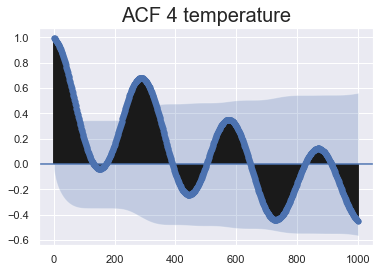

In [16]:
sgt.plot_acf(df.temperature, zero = False, lags = 1000)
plt.title("ACF 4 temperature", size = 20)
plt.show()

## Partial Auto Correlation Function (PACF)

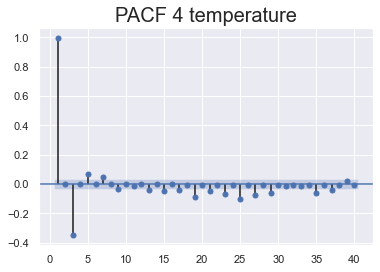

In [17]:
sgt.plot_pacf(df.temperature, lags = 40, alpha = 0.05, zero = False, method = ('ols'))
plt.title("PACF 4 temperature", size = 20)
plt.show()

# Temperature

In [ ]:
start_date = df_test.index[0]
end_date = df_test.index[points_per_day-1]

## AR

In [19]:
print("AR(1)")
model_t_ar_1 = SARIMAX(df_train.temperature, order=(1,0,0))
results_t_ar_1 = model_t_ar_1.fit()
print(results_t_ar_1.summary())

print("AR(2)") #PARAMETRI NON SIGNIFICATIVI
model_t_ar_2 = SARIMAX(df_train.temperature, order=(2,0,0))
results_t_ar_2 = model_t_ar_2.fit()
print(results_t_ar_2.summary())

print("AR(3)") #PARAMETRI NON SIGNIFICATIVI
model_t_ar_3 = SARIMAX(df_train.temperature, order=(3,0,0))
results_t_ar_3 = model_t_ar_3.fit()
print(results_t_ar_3.summary())

print("AR(4)") #PARAMETRI NON SIGNIFICATIVI
model_t_ar_4 = ARIMA(df_train.temperature, order=(4,0,0))
results_t_ar_4 = model_t_ar_4.fit()
print(results_t_ar_4.summary())

print("AR(5)") 
model_t_ar_5 = ARIMA(df_train.temperature, order=(5,0,0))
results_t_ar_5 = model_t_ar_5.fit()
print(results_t_ar_5.summary())

AR(1)
                               SARIMAX Results                                
Dep. Variable:            temperature   No. Observations:                 2880
Model:               SARIMAX(1, 0, 0)   Log Likelihood                2262.752
Date:                Sun, 19 Jul 2020   AIC                          -4521.503
Time:                        22:57:47   BIC                          -4509.572
Sample:                    07-07-2020   HQIC                         -4517.203
                         - 07-17-2020                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          1.0000   3.15e-05   3.17e+04      0.000       1.000       1.000
sigma2         0.0121      0.000    110.574      0.000       0.012       0.012
Ljung-Box (Q):                      703.25   J

In [21]:
print("AR(1):  \t LL = ", results_t_ar_1.llf, "\t AIC = ", results_t_ar_1.aic)
print("AR(5):  \t LL = ", results_t_ar_5.llf, "\t AIC = ", results_t_ar_5.aic)

AR(1):  	 LL =  2262.7516816238985 	 AIC =  -4521.503363247797
AR(5):  	 LL =  2459.7534280113045 	 AIC =  -4905.506856022609


In [23]:
print("\nLLR test AR(1)-AR(5) = " + str(LLR_test(results_t_ar_1, results_t_ar_2, DF = 4)))


LLR test AR(1)-AR(5) = 1.0


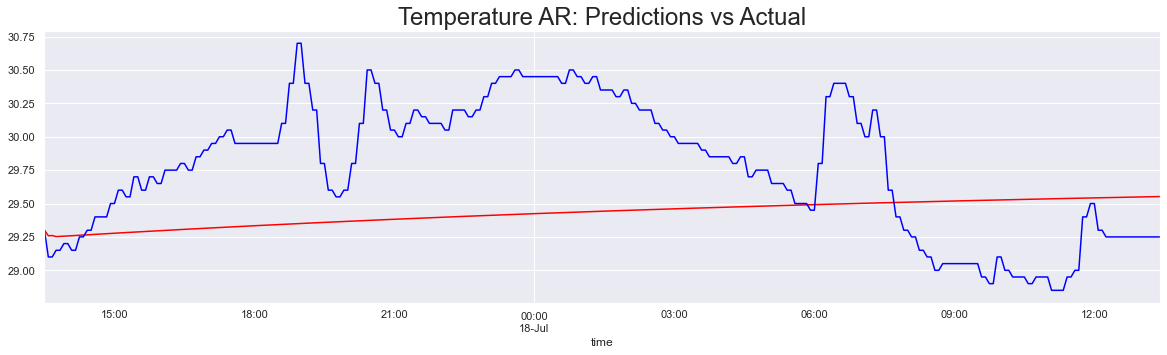

MAE 0.5496633305509864
MSE 0.3917654667002183


In [33]:
df_pred = results_t_ar_5.predict(start = start_date, end = end_date)

df_pred[start_date:end_date].plot(figsize = (20,5), color = "red")
df_test.temperature[start_date:end_date].plot(color = "blue")
plt.title("Temperature AR: Predictions vs Actual", size = 24)
plt.show()                          

print("MAE "+str(mean_absolute_error(df_test.temperature[start_date:end_date], df_pred[start_date:end_date])))
print("MSE "+str(mean_squared_error(df_test.temperature[start_date:end_date], df_pred[start_date:end_date])))

## MA

In [34]:
model_t_ma_1 = SARIMAX(df_train.temperature, order=(0,0,1))
results_t_ma_1 = model_t_ma_1.fit()
print(results_t_ma_1.summary())

model_t_ma_2 = ARIMA(df_train.temperature, order=(0,0,2))
results_t_ma_2 = model_t_ma_2.fit(start_ar_lags=100)
print(results_t_ma_2.summary())

                               SARIMAX Results                                
Dep. Variable:            temperature   No. Observations:                 2880
Model:               SARIMAX(0, 0, 1)   Log Likelihood              -11873.840
Date:                Sun, 19 Jul 2020   AIC                          23751.681
Time:                        23:03:39   BIC                          23763.612
Sample:                    07-07-2020   HQIC                         23755.981
                         - 07-17-2020                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1          0.9996      0.003    385.055      0.000       0.995       1.005
sigma2       222.5976     51.777      4.299      0.000     121.116     324.079
Ljung-Box (Q):                    46904.29   Jarque-

In [35]:
print("MA(1):  \t LL = ", results_t_ma_1.llf, "\t AIC = ", results_t_ma_1.aic)
print("MA(2):  \t LL = ", results_t_ma_2.llf, "\t AIC = ", results_t_ma_2.aic)

MA(1):  	 LL =  -11873.840278133075 	 AIC =  23751.68055626615
MA(2):  	 LL =  -2388.8233281780012 	 AIC =  4785.6466563560025


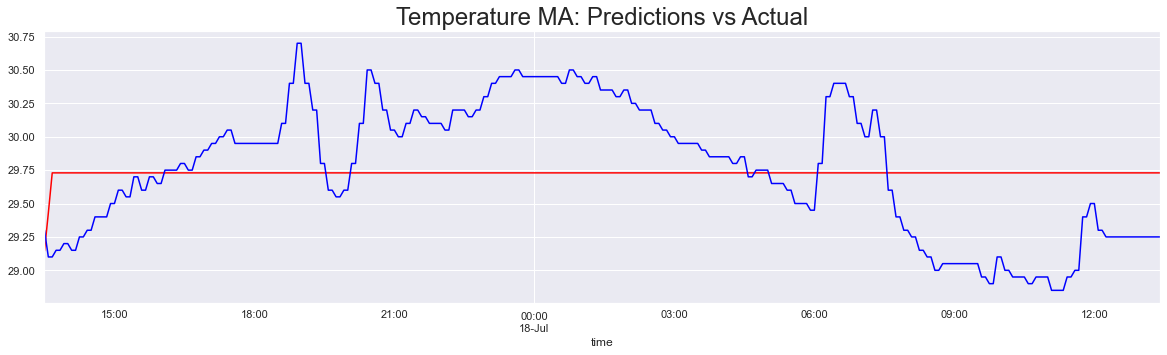

MAE 0.42561187187171146
MSE 0.2424488255628046


In [37]:
df_pred = results_t_ma_2.predict(start = start_date, end = end_date)

df_pred[start_date:end_date].plot(figsize = (20,5), color = "red")
df_test.temperature[start_date:end_date].plot(color = "blue")
plt.title("Temperature MA: Predictions vs Actual", size = 24)
plt.show()                          

print("MAE "+str(mean_absolute_error(df_test.temperature[start_date:end_date], df_pred[start_date:end_date])))
print("MSE "+str(mean_squared_error(df_test.temperature[start_date:end_date], df_pred[start_date:end_date])))

## ARMA

In [39]:
print("\nARMA(1,1)") #NON SIGNIFICATIVO
results_t_ar_1_ma_1 = ARMA(df_train.temperature, order=(1,1)).fit()
print(results_t_ar_1_ma_1.summary())

print("\nARMA(2,1)") 
results_t_ar_2_ma_1 = ARMA(df_train.temperature, order=(2,1)).fit()
print(results_t_ar_2_ma_1.summary())

print("\nARMA(1,2)") #NON SIGNIFICATIVO
results_t_ar_1_ma_2 = ARMA(df_train.temperature, order=(1,2)).fit()
print(results_t_ar_1_ma_2.summary())

print("\nARMA(2,2)") #NON SIGNIFICATIVO
results_t_ar_2_ma_2 = ARMA(df_train.temperature, order=(2,2)).fit()
print(results_t_ar_2_ma_2.summary())

print("\nARMA(3,1)") #NON SIGNIFICATIVO
results_t_ar_3_ma_1 = ARMA(df_train.temperature, order=(3,1)).fit()
print(results_t_ar_3_ma_1.summary())

print("\nARMA(1,3)") #NON SIGNIFICATIVO
results_t_ar_1_ma_3 = ARMA(df_train.temperature, order=(1,3)).fit()
print(results_t_ar_1_ma_3.summary())

print("\nARMA(3,2)") #NON SIGNIFICATIVO
results_t_ar_3_ma_2 = ARMA(df_train.temperature, order=(3,2)).fit()
print(results_t_ar_3_ma_2.summary())

print("\nARMA(2,3)") 
results_t_ar_2_ma_3 = ARMA(df_train.temperature, order=(2,3)).fit()
print(results_t_ar_2_ma_3.summary())

print("\nARMA(3,3)") #NON SIGNIFICATIVO
results_t_ar_3_ma_3 = ARMA(df_train.temperature, order=(3,3)).fit()
print(results_t_ar_3_ma_3.summary())


ARMA(1,1)
                              ARMA Model Results                              
Dep. Variable:            temperature   No. Observations:                 2880
Model:                     ARMA(1, 1)   Log Likelihood                2267.647
Method:                       css-mle   S.D. of innovations              0.110
Date:                Sun, 19 Jul 2020   AIC                          -4527.293
Time:                        23:06:00   BIC                          -4503.431
Sample:                    07-07-2020   HQIC                         -4518.692
                         - 07-17-2020                                         
                        coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------
const                29.6772      0.774     38.345      0.000      28.160      31.194
ar.L1.temperature     0.9977      0.001    891.610      0.000       0.995       1.000
ma.L1.tempera

                              ARMA Model Results                              
Dep. Variable:            temperature   No. Observations:                 2880
Model:                     ARMA(1, 3)   Log Likelihood                2446.703
Method:                       css-mle   S.D. of innovations              0.103
Date:                Sun, 19 Jul 2020   AIC                          -4881.407
Time:                        23:06:04   BIC                          -4845.613
Sample:                    07-07-2020   HQIC                         -4868.505
                         - 07-17-2020                                         
                        coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------
const                29.6885      0.672     44.187      0.000      28.372      31.005
ar.L1.temperature     0.9965      0.001    695.212      0.000       0.994       0.999
ma.L1.temperature     0.

In [53]:
print("ARMA(2,1):  \t LL = ", results_t_ar_2_ma_1.llf, "\t AIC = ", results_t_ar_2_ma_1.aic)
print("ARMA(2,3):  \t LL = ", results_t_ar_2_ma_3.llf, "\t AIC = ", results_t_ar_2_ma_3.aic)

ARMA(2,1):  	 LL =  2306.4637564867467 	 AIC =  -4602.927512973493
ARMA(2,3):  	 LL =  2465.435962845518 	 AIC =  -4916.871925691036


In [54]:
print("\nARMA(2,1) vs ARMA(2,3) ",LLR_test(results_t_ar_2_ma_1, results_t_ar_2_ma_3, DF=1))


ARMA(2,1) vs ARMA(2,3)  0.0


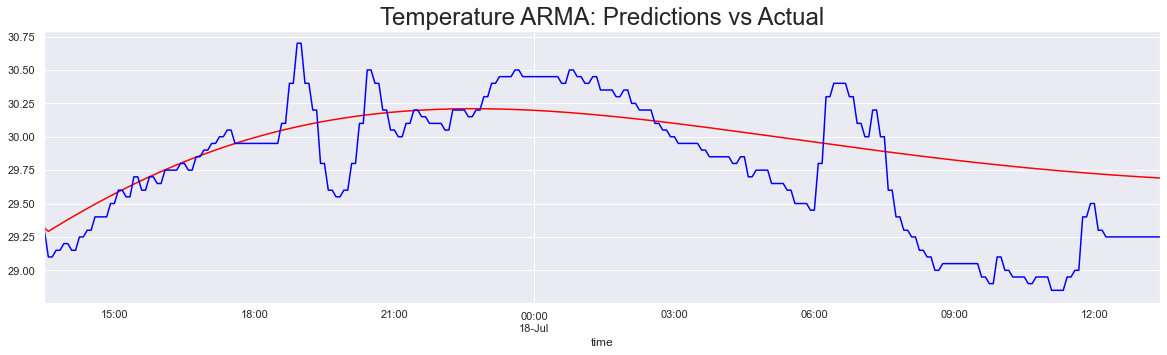

MAE 0.300539921110969
MSE 0.15557153760609158


In [44]:
df_pred = results_t_ar_2_ma_3.predict(start = start_date, end = end_date)

df_pred[start_date:end_date].plot(figsize = (20,5), color = "red")
df_test.temperature[start_date:end_date].plot(color = "blue")
plt.title("Temperature ARMA: Predictions vs Actual", size = 24)
plt.show()                          

print("MAE "+str(mean_absolute_error(df_test.temperature[start_date:end_date], df_pred[start_date:end_date])))
print("MSE "+str(mean_squared_error(df_test.temperature[start_date:end_date], df_pred[start_date:end_date])))

## ARIMA

In [49]:
print("\nARIMA(1,1,1)") 
results_t_ar_1_i_1_ma_1 = SARIMAX(df_train.temperature, order=(1,1,1)).fit()
print(results_t_ar_1_i_1_ma_1.summary())

print("\nARIMA(2,1,1)")
results_t_ar_2_i_1_ma_1 = SARIMAX(df_train.temperature, order=(2,1,1)).fit()
print(results_t_ar_2_i_1_ma_1.summary())

print("\nARIMA(1,1,2)") #NON SIGNIFICATIVO
results_t_ar_1_i_1_ma_2 = SARIMAX(df_train.temperature, order=(1,1,2)).fit()
print(results_t_ar_1_i_1_ma_2.summary())

print("\nARIMA(1,1,3)") #NON SIGNIFICATIVO
results_t_ar_1_i_1_ma_3 = SARIMAX(df_train.temperature, order=(1,1,3)).fit()
print(results_t_ar_1_i_1_ma_3.summary())

print("\nARIMA(3,1,1)") 
results_t_ar_3_i_1_ma_1 = SARIMAX(df_train.temperature, order=(3,1,1)).fit()
print(results_t_ar_3_i_1_ma_1.summary())

print("\nARIMA(3,1,2)") #NON SIGNIFICATIVO
results_t_ar_3_i_1_ma_2 = SARIMAX(df_train.temperature, order=(3,1,2)).fit()
print(results_t_ar_3_i_1_ma_2.summary())

print("\nARIMA(3,1,3)") #NON SIGNIFICATIVO
results_t_ar_3_i_1_ma_3 = SARIMAX(df_train.temperature, order=(3,1,3)).fit()
print(results_t_ar_3_i_1_ma_3.summary())


############################

print("\nARIMA(1,2,1)")
results_t_ar_1_i_2_ma_1 = SARIMAX(df_train.temperature, order=(1,2,1)).fit()
print(results_t_ar_1_i_2_ma_1.summary())

print("\nARIMA(2,2,1)")
results_t_ar_2_i_2_ma_1 = SARIMAX(df_train.temperature, order=(2,2,1)).fit()
print(results_t_ar_2_i_2_ma_1.summary())

print("\nARIMA(1,2,2)") 
results_t_ar_1_i_2_ma_2 = SARIMAX(df_train.temperature, order=(1,2,2)).fit()
print(results_t_ar_1_i_2_ma_2.summary())

print("\nARIMA(2,2,2)") #NON SIGNIFICATIVO
results_t_ar_2_i_2_ma_2 = SARIMAX(df_train.temperature, order=(2,2,2)).fit()
print(results_t_ar_2_i_2_ma_2.summary())


print("\nARIMA(1,2,3)") #NON SIGNIFICATIVO
results_t_ar_1_i_2_ma_3 = SARIMAX(df_train.temperature, order=(1,2,3)).fit()
print(results_t_ar_1_i_2_ma_3.summary())

print("\nARIMA(3,2,1)") #NON SIGNIFICATIVO
results_t_ar_3_i_2_ma_1 = SARIMAX(df_train.temperature, order=(3,2,1)).fit()
print(results_t_ar_3_i_2_ma_1.summary())

print("\nARIMA(3,2,2)") #NON SIGNIFICATIVO
results_t_ar_3_i_2_ma_2 = SARIMAX(df_train.temperature, order=(3,2,2)).fit()
print(results_t_ar_3_i_2_ma_2.summary())

print("\nARIMA(3,2,3)") #NON SIGNIFICATIVO
results_t_ar_3_i_2_ma_3 = SARIMAX(df_train.temperature, order=(3,2,3)).fit()
print(results_t_ar_3_i_2_ma_3.summary())



ARIMA(1,1,1)
                               SARIMAX Results                                
Dep. Variable:            temperature   No. Observations:                 2880
Model:               SARIMAX(1, 1, 1)   Log Likelihood                2267.626
Date:                Sun, 19 Jul 2020   AIC                          -4529.252
Time:                        23:15:10   BIC                          -4511.356
Sample:                    07-07-2020   HQIC                         -4522.802
                         - 07-17-2020                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1        2.96e-08   2.39e-14   1.24e+06      0.000    2.96e-08    2.96e-08
ma.L1      -5.013e-08   1.07e-14  -4.69e+06      0.000   -5.01e-08   -5.01e-08
sigma2         0.0121      0.000    11

                               SARIMAX Results                                
Dep. Variable:            temperature   No. Observations:                 2880
Model:               SARIMAX(3, 1, 2)   Log Likelihood                2456.974
Date:                Sun, 19 Jul 2020   AIC                          -4901.947
Time:                        23:15:13   BIC                          -4866.156
Sample:                    07-07-2020   HQIC                         -4889.046
                         - 07-17-2020                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1       4.795e-05    224.356   2.14e-07      1.000    -439.729     439.729
ar.L2          0.2219      0.042      5.285      0.000       0.140       0.304
ar.L3       1.497e-06    209.716   7.14e-09      1.0

                               SARIMAX Results                                
Dep. Variable:            temperature   No. Observations:                 2880
Model:               SARIMAX(2, 2, 2)   Log Likelihood                2443.468
Date:                Sun, 19 Jul 2020   AIC                          -4876.937
Time:                        23:15:21   BIC                          -4847.112
Sample:                    07-07-2020   HQIC                         -4866.186
                         - 07-17-2020                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.0438      0.274     -0.160      0.873      -0.580       0.493
ar.L2          0.3273      0.011     30.704      0.000       0.306       0.348
ma.L1         -0.9533      0.320     -2.978      0.0

In [50]:
print("ARMA(1,1,1):  \t LL = ", results_t_ar_1_i_1_ma_1.llf, "\t AIC = ", results_t_ar_1_i_1_ma_1.aic)
print("ARMA(2,1,1):  \t LL = ", results_t_ar_2_i_1_ma_1.llf, "\t AIC = ", results_t_ar_2_i_1_ma_1.aic)
print("ARMA(3,1,1):  \t LL = ", results_t_ar_3_i_1_ma_1.llf, "\t AIC = ", results_t_ar_3_i_1_ma_1.aic)
print("ARMA(1,2,1):  \t LL = ", results_t_ar_1_i_2_ma_1.llf, "\t AIC = ", results_t_ar_1_i_2_ma_1.aic)
print("ARMA(2,2,1):  \t LL = ", results_t_ar_2_i_2_ma_1.llf, "\t AIC = ", results_t_ar_2_i_2_ma_1.aic)
print("ARMA(1,2,2):  \t LL = ", results_t_ar_1_i_2_ma_2.llf, "\t AIC = ", results_t_ar_1_i_2_ma_2.aic)

ARMA(1,1,1):  	 LL =  2267.6259982388865 	 AIC =  -4529.251996477773
ARMA(2,1,1):  	 LL =  2451.9753679003743 	 AIC =  -4895.950735800749
ARMA(3,1,1):  	 LL =  2451.975367900289 	 AIC =  -4893.950735800578
ARMA(1,2,1):  	 LL =  2293.588692069299 	 AIC =  -4581.177384138598
ARMA(2,2,1):  	 LL =  2443.299510966861 	 AIC =  -4878.599021933722
ARMA(1,2,2):  	 LL =  2340.6171085892283 	 AIC =  -4673.234217178457


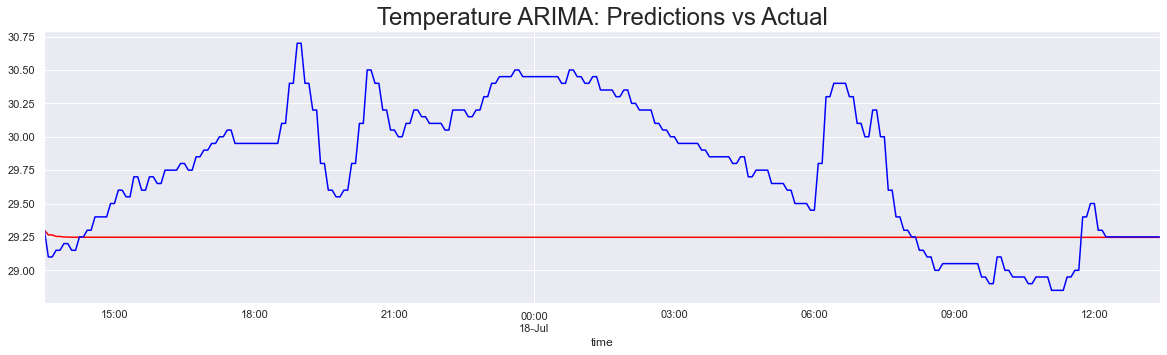

MAE 0.6032498240981625
MSE 0.5160173630212088


In [52]:
df_pred = results_t_ar_2_i_1_ma_1.predict(start = start_date, end = end_date)

df_pred[start_date:end_date].plot(figsize = (20,5), color = "red")
df_test.temperature[start_date:end_date].plot(color = "blue")
plt.title("Temperature ARIMA: Predictions vs Actual", size = 24)
plt.show()                          

print("MAE "+str(mean_absolute_error(df_test.temperature[start_date:end_date], df_pred[start_date:end_date])))
print("MSE "+str(mean_squared_error(df_test.temperature[start_date:end_date], df_pred[start_date:end_date])))